In [1]:
%matplotlib inline 
#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import random            as random
import numpy             as np
import pandas            as pd
#import tables            as tb
import matplotlib.pyplot as plt
import os 

In [3]:
import xyimg.dataprep as dp
import xyimg.cnn      as cnn

## Test

In [4]:
path = os.environ['LPRDATADIR']+'xymm/'

pressure = '13bar'
coors  = ('x', 'y')
widths = (10, 10)
frame  = dp.frames[pressure]
ifile = path + dp.xymm_filename(coors, widths, frame, prefix = 'xymm_'+pressure)

cnn.test(ifile)

input filename  /scratch/next/data/NEXT100/pressure_topology/xymm/xymm_13bar_xy_10x10_100.npz
output filename  /scratch/next/data/NEXT100/pressure_topology/xymm/test_cnn_xymm_13bar_xy_10x10_100.npz
--- data set ---
Dataset : 
   labels   : ['esum', 'emax', 'ecount']
   x shape  : (205612, 3, 10, 10)
   y shape  : (205612, 1)
   z labels : ['seg', 'ext']
   z shape  : (205612, 2, 10, 10)

Event Image tensor  (3, 10, 10)
CNN : 
   [200, 3, 10, 10] => [200, 6, 5, 5] => [200, 12, 3, 3]=> [200, 24, 2, 2] => [200, 96] => [200, 6]
 => [200, 1]

Epoch:  train 0.039 +- 0.058  validation 0.013 +- 0.003
Epoch:  train 0.009 +- 0.003  validation 0.005 +- 0.002
Epoch:  train 0.005 +- 0.002  validation 0.004 +- 0.002
Epoch:  train 0.004 +- 0.002  validation 0.003 +- 0.002
Test  accuracy 99.82
save cnn results at  /scratch/next/data/NEXT100/pressure_topology/xymm/test_cnn_xymm_13bar_xy_10x10_100.npz
--- data set inv ---
Dataset : 
   labels   : ['seg', 'ext']
   x shape  : (205612, 2, 10, 10)
   y sha

True

## RUN CNN

In [54]:
ipath = os.environ['LPRDATADIR']+'xymm/'
opath = 'temp/'

pressure   = '13bar'
coors      = ('x', 'y')
widths     = (10, 10)
labels     = ['test']
cnn_name   = 'temp_cnn_'
nepochs    = 10

idata, odata = cnn.production(ipath, opath, pressure, coors, widths, labels, nepochs = nepochs, cnn_name = cnn_name)


input file  :  /scratch/next/data/NEXT100/pressure_topology/xymm/xymm_13bar_xy_10x10_100.npz
output file :  temp//temp_cnn_test_xymm_13bar_xy_10x10_100.npz
Dataset : 
   labels   : ['test']
   x shape  : (200038, 1, 10, 10)
   y shape  : (200038, 1)
   z labels : ['seg', 'ext']
   z shape  : (200038, 2, 10, 10)

Event Image tensor  (1, 10, 10)
CNN : 
   [200, 1, 10, 10] => [200, 2, 5, 5] => [200, 4, 3, 3]=> [200, 8, 2, 2] => [200, 32] => [200, 2]
 => [200, 1]

Epoch:  train 0.105 +- 0.143  validation 0.034 +- 0.007
Epoch:  train 0.025 +- 0.006  validation 0.019 +- 0.005
Epoch:  train 0.017 +- 0.005  validation 0.013 +- 0.004
Epoch:  train 0.013 +- 0.004  validation 0.011 +- 0.004
Epoch:  train 0.012 +- 0.004  validation 0.010 +- 0.004
Epoch:  train 0.011 +- 0.003  validation 0.009 +- 0.003
Epoch:  train 0.010 +- 0.003  validation 0.009 +- 0.003
Epoch:  train 0.009 +- 0.003  validation 0.008 +- 0.003
Epoch:  train 0.009 +- 0.003  validation 0.008 +- 0.003
Epoch:  train 0.009 +- 0.003  v

## Ana CNN

In [5]:
path       = os.environ['LPRDATADIR']
ipath      = path + 'xymm/'
opath      = path + 'cnn/'
pressure   = '5bar'
projection = ('x', 'y')
widths     = (10, 10)
labels     = ['seg',]

idata, odata = cnn.retrieve_cnn_data(ipath, opath, pressure, projection, widths, labels)

data file :  /scratch/next/data/NEXT100/pressure_topology/xymm/xymm_5bar_xy_10x10_304.npz
cnn file  : /scratch/next/data/NEXT100/pressure_topology/cnn//cnn_seg_xymm_5bar_xy_10x10_304.npz


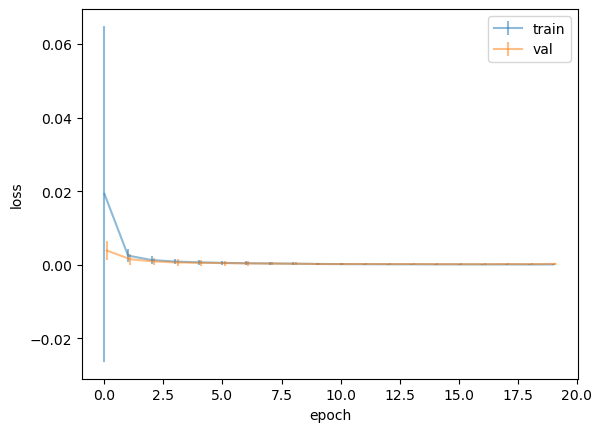

In [9]:
cnn.plot_epochs(odata['epochs'])

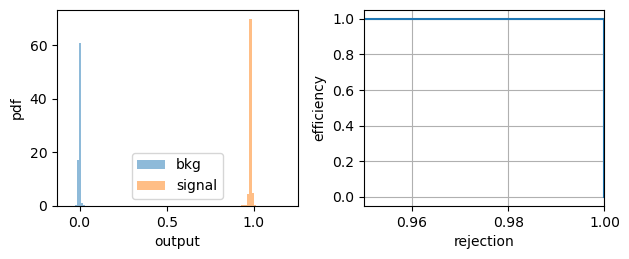

In [10]:
cnn.plot_roc(odata['y'], odata['yp'], 0.95)

event  162960
target test       0
target test pred  -0.001874297857284546
success           True
total     seg 33.0


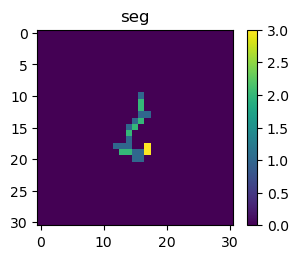

In [95]:
cnn.plot_event(idata, odata, labels)